https://data-dive.com/finetune-german-gpt2-on-tpu-transformers-tensorflow-for-text-generation-of-reviews

In [ ]:
!nvidia-smi

Tue Oct 11 06:14:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers==4.22.2
!pip install datasets

import os
import warnings
import re
import random
import datasets
import transformers
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from transformers import AutoTokenizer, TFGPT2LMHeadModel
from datasets import Dataset, load_dataset

pd.options.display.max_colwidth = 6000
pd.options.display.max_rows = 400
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")
# Log Level and suppress extensive tf warnings
os.environ["TRANSFORMERS_VERBOSITY"] = "info"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)
print(transformers.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

2.8.2
4.22.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/Thesis/Code/GenerativeDataAugmentation/Coba11/join_dataset1.csv'

In [ ]:
# read data
data = pd.read_csv(data_path, encoding="utf-8")
data.head(3)

,Unnamed: 0,Text,Emotion
0,0,Thanks! I'm glad you got a kick out of it.,joy
1,1,I'm more surprised the dash cam was functioning properly. Usually around these incidents 3 of them were not recording and one had the lens cap on...,surprise
2,2,i dont know how i feel about my beloved teams draft,love


In [ ]:
encoded_dict = {'anger':0, 'fear':1, 'joy':2, 'love':3, 'sadness':4, 'surprise':5, 'disgust':6}
encoded_token = {'anger':"<|emo_anger|>", 'fear':"<|emo_fear|>", 'joy':"<|emo_joy|>", 'love':"<|emo_love|>", 'sadness':"<|emo_sad|>", 'surprise':"<|emo_surprise|>", 'disgust':"<|emo_disgust|>"}
data['Encode'] = data.Emotion.map(encoded_dict)
data['Token'] = data.Emotion.map(encoded_token)

In [ ]:
data

,Unnamed: 0,Text,Emotion,Encode,Token
0,0,Thanks! I'm glad you got a kick out of it.,joy,2,<|emo_joy|>
1,1,I'm more surprised the dash cam was functioning properly. Usually around these incidents 3 of them were not recording and one had the lens cap on...,surprise,5,<|emo_surprise|>
2,2,i dont know how i feel about my beloved teams draft,love,3,<|emo_love|>
3,3,when i learnt that my best friend had failed the exams,anger,0,<|emo_anger|>
4,4,i feel as though that talking for a month is acceptable but please pretty please get together after that,joy,2,<|emo_joy|>
...,...,...,...,...,...
65023,65023,I love truck drivers!!,love,3,<|emo_love|>
65024,65024,I knew I'd see him here eventually. I really like his animations. They're cute and funny,joy,2,<|emo_joy|>
65025,65025,Nope what’s it about?,surprise,5,<|emo_surprise|>
65026,65026,Removed and warned. R1,anger,0,<|emo_anger|>


In [ ]:
data["Token"].value_counts()

<|emo_joy|>         14744
<|emo_sad|>         12555
<|emo_anger|>       10793
<|emo_love|>         9832
<|emo_surprise|>     6233
<|emo_fear|>         5570
<|emo_disgust|>      5301
Name: Token, dtype: int64

In [ ]:
# add rating indicator as first word of comment
data["Text"] = data["Token"] + " " + data["Text"]
dataset = data[["Text"]]
dataset.columns = ["Text"]
dataset.to_csv("/content/drive/MyDrive/Thesis/Code/GenerativeDataAugmentation/Coba11/comment_clean.csv", encoding='utf-8', index=False)
dataset.head(10)

,Text
0,<|emo_joy|> Thanks! I'm glad you got a kick out of it.
1,<|emo_surprise|> I'm more surprised the dash cam was functioning properly. Usually around these incidents 3 of them were not recording and one had the lens cap on...
2,<|emo_love|> i dont know how i feel about my beloved teams draft
3,<|emo_anger|> when i learnt that my best friend had failed the exams
4,<|emo_joy|> i feel as though that talking for a month is acceptable but please pretty please get together after that
5,<|emo_joy|> i feel like the addition of sweet fresh corn really adds a touch of summer to an otherwise heavy fall dish
6,<|emo_disgust|> They have disagreed with a bunch of individual calls but not tied it together
7,<|emo_fear|> im trying to be intuitive often just makes me feel sort of confused and nauseous
8,"<|emo_joy|> It’s good to see that all the [NAME] are relatively old, meaning they will all eventually die out."
9,<|emo_sad|> i could have just kept going but i could tell that she was feeling really defeated and needed a friend


In [ ]:
# Read data from file and load as dataset
data = pd.read_csv("/content/drive/MyDrive/Thesis/Code/GenerativeDataAugmentation/Coba11/comment_clean.csv")
data = Dataset.from_pandas(data)
data

Dataset({
    features: ['Text'],
    num_rows: 65028
})

In [ ]:
MAX_TOKENS = 128
ANG_TOKEN = "<|emo_anger|>"
FEA_TOKEN = "<|emo_fear|>"
JOY_TOKEN = "<|emo_joy|>"
LOV_TOKEN = "<|emo_love|>"
SAD_TOKEN = "<|emo_sad|>"
SUR_TOKEN = "<|emo_surprise|>"
DIS_TOKEN = "<|emo_disgust|>"
BOS_TOKENS = [ANG_TOKEN, FEA_TOKEN, JOY_TOKEN, LOV_TOKEN, SAD_TOKEN, SUR_TOKEN, DIS_TOKEN]
EOS_TOKEN = "<|endoftext|>"
PAD_TOKEN = "<|pad|>"

# this will download and initialize the pre trained tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "gpt2-medium",
    eos_token=EOS_TOKEN,
    pad_token=PAD_TOKEN,
    max_length=MAX_TOKENS,
    is_split_into_words=True,
)
tokenizer.add_tokens(BOS_TOKENS, special_tokens=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


7

In [ ]:
print('Text : ', dataset.Text[1])
print('Token: ', tokenizer.tokenize(dataset.Text[1]))

Text :  <|emo_surprise|> I'm more surprised the dash cam was functioning properly. Usually around these incidents 3 of them were not recording and one had the lens cap on...
Token:  ['<|emo_surprise|>', 'ĠI', "'m", 'Ġmore', 'Ġsurprised', 'Ġthe', 'Ġdash', 'Ġcam', 'Ġwas', 'Ġfunctioning', 'Ġproperly', '.', 'ĠUsually', 'Ġaround', 'Ġthese', 'Ġincidents', 'Ġ3', 'Ġof', 'Ġthem', 'Ġwere', 'Ġnot', 'Ġrecording', 'Ġand', 'Ġone', 'Ġhad', 'Ġthe', 'Ġlens', 'Ġcap', 'Ġon', '...']


In [ ]:
%%time

output = {}
# texts to numeric vectors of MAX_TOKENS
def tokenize_function(examples, tokenizer=tokenizer):
    # Add start and end token to each comment
    examples = [ex + EOS_TOKEN for ex in examples["Text"]]
    # tokenizer created input_ids and attention_mask as output
    output = tokenizer(
        examples,
        add_special_tokens=True,  # Only adds pad not eos and bos
        max_length=MAX_TOKENS,
        truncation=True,
        pad_to_max_length=True,
    )
    # shift labels for next token prediction
    # set padding token labels to -100 which is ignored in loss computation
    output["labels"] = [x[1:] for x in output["input_ids"]]
    output["labels"] = [
        [-100 if x == tokenizer.pad_token_id else x for x in y]
        for y in output["labels"]
    ]
    # truncate input ids and attention mask to account for label shift
    output["input_ids"] = [x[:-1] for x in output["input_ids"]]
    output["attention_mask"] = [x[:-1] for x in output["attention_mask"]]
    return output


data = data.map(
    tokenize_function,
    batched=True,
    # num_proc=strategy.num_replicas_in_sync,
    remove_columns=["Text"],
    load_from_cache_file=True,
)
print(data)

  0%|          | 0/66 [00:00<?, ?ba/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 65028
})
CPU times: user 16.8 s, sys: 244 ms, total: 17 s
Wall time: 13.5 s


In [ ]:
# Load Inputs and create test and train split
data.save_to_disk("/content/drive/MyDrive/Thesis/Code/GenerativeDataAugmentation/Coba11/reviews_tokenized_128_ratings")
data = datasets.load_from_disk("/content/drive/MyDrive/Thesis/Code/GenerativeDataAugmentation/Coba11/reviews_tokenized_128_ratings")
data.set_format(type="python", columns=["input_ids", "attention_mask", "labels"])
data = data.train_test_split(
    test_size=0.10, shuffle=True, seed=1, load_from_cache_file=True,
)
print(data)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 58525
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6503
    })
})


In [ ]:
%%time
# prepare for use in tensorflow
train_tensor_inputs = tf.convert_to_tensor(data["train"]["input_ids"])
train_tensor_labels = tf.convert_to_tensor(data["train"]["labels"])
train_tensor_mask = tf.convert_to_tensor(data["train"]["attention_mask"])
train = tf.data.Dataset.from_tensor_slices(
    (
        {"input_ids": train_tensor_inputs, "attention_mask": train_tensor_mask},
        train_tensor_labels,
    )
)

test_tensor_inputs = tf.convert_to_tensor(data["test"]["input_ids"])
test_tensor_labels = tf.convert_to_tensor(data["test"]["labels"])
test_tensor_mask = tf.convert_to_tensor(data["test"]["attention_mask"])
test = tf.data.Dataset.from_tensor_slices(
    (
        {"input_ids": test_tensor_inputs, "attention_mask": test_tensor_mask},
        test_tensor_labels,
    )
)

CPU times: user 18.1 s, sys: 1.23 s, total: 19.3 s
Wall time: 19.5 s


In [ ]:
# Model params
BATCH_SIZE_PER_REPLICA = 1
EPOCHS = 3
INITAL_LEARNING_RATE = 0.00001
try:
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA 
except NameError as e:
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA
BUFFER_SIZE = len(train)

# prepare data for consumption
train_ds = (
    train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
)
test_ds = test.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
# Drecreasing learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    INITAL_LEARNING_RATE,
    decay_steps=500,
    decay_rate=0.7,
    staircase=True)

# initialize model, use_cache=False important! else wrong shape at loss calc

model = TFGPT2LMHeadModel.from_pretrained(
    "gpt2-medium",
    use_cache=False,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
)
model.resize_token_embeddings(len(tokenizer))
optimizer = tf.keras.optimizers.Adam(learning_rate=INITAL_LEARNING_RATE)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss)
model.summary()

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2-medium.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Model: "tfgpt2lm_head_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLaye  multiple                 354831360 
 r)                                                              
                                                                 
Total params: 354,831,360
Trainable params: 354,831,360
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Stop training when validation acc starts dropping
# Save checkpoint of model after each period
now = datetime.now().strftime("%Y-%m-%d_%H%M")
# Create callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", verbose=1, min_delta=0.1, patience=5, restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "/content/drive/MyDrive/Thesis/Code/GenerativeDataAugmentation/Coba11/" + now + "_GPT2-Model_{epoch:02d}_{val_loss:.4f}.tf",
        monitor="val_loss",
        save_best_only=True,
        verbose=1,
    ),
]

In [ ]:
%%time
# Train Model
steps_per_epoch = int(BUFFER_SIZE // BATCH_SIZE)
print(
    f"Model Params:\nbatch_size: {BATCH_SIZE}\nEpochs: {EPOCHS}\n"
    f"Step p. Epoch: {steps_per_epoch}\n"
    f"Initial Learning rate: {INITAL_LEARNING_RATE}"
)
hist = model.fit(
    train_ds,
    validation_data=test_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
)

Model Params:
batch_size: 1
Epochs: 3
Step p. Epoch: 58525
Initial Learning rate: 1e-05
Epoch 1/3
58525/58525 [==============================] - ETA: 0s - loss: 3.7458
Epoch 1: val_loss improved from inf to 3.45567, saving model to /content/drive/MyDrive/Thesis/Code/GenerativeDataAugmentation/Coba11/2022-10-11_0616_GPT2-Model_01_3.4557.tf


58525/58525 [==============================] - 9298s 159ms/step - loss: 3.7458 - val_loss: 3.4557
Epoch 2/3
58525/58525 [==============================] - ETA: 0s - loss: 3.2121
Epoch 2: val_loss improved from 3.45567 to 3.24184, saving model to /content/drive/MyDrive/Thesis/Code/GenerativeDataAugmentation/Coba11/2022-10-11_0616_GPT2-Model_02_3.2418.tf


58525/58525 [==============================] - 9257s 158ms/step - loss: 3.2121 - val_loss: 3.2418
Epoch 3/3
58525/58525 [==============================] - ETA: 0s - loss: 2.8089
Epoch 3: val_loss improved from 3.24184 to 3.07943, saving model to /content/drive/MyDrive/Thesis/Code/GenerativeDataAugmentation/Coba11/2022-10-11_0616_GPT2-Model_03_3.0794.tf


58525/58525 [==============================] - 9287s 159ms/step - loss: 2.8089 - val_loss: 3.0794
CPU times: user 6h 1min 25s, sys: 1h 46min 56s, total: 7h 48min 21s
Wall time: 7h 44min 3s


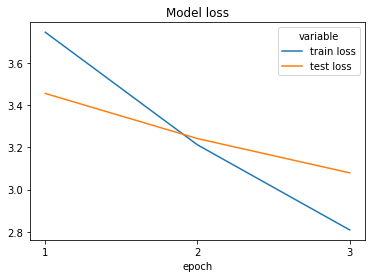

In [ ]:
loss = pd.DataFrame(
    {"train loss": hist.history["loss"], "test loss": hist.history["val_loss"]}
).melt()
loss["epoch"] = loss.groupby("variable").cumcount() + 1
sns.lineplot(x="epoch", y="value", hue="variable", data=loss).set(
    title="Model loss",
    ylabel="",
    xticks=range(1, loss["epoch"].max() + 1),
    xticklabels=loss["epoch"].unique(),
);

In [ ]:
#Count perplexity from exponential of crossentropy

trainLoss = hist.history["loss"]
train_perplexity = tf.exp(trainLoss)
print(train_perplexity)

tf.Tensor([42.344646 24.83099  16.592031], shape=(3,), dtype=float32)


In [ ]:
from transformers import pipeline

review = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

In [ ]:
gen_pos = review("<|emo_anger|>", max_length=50, num_return_sequences=6)
pd.DataFrame(gen_pos)

,generated_text
0,<|emo_anger|> What the fuck is that horrible picture
1,<|emo_anger|> I hate it when mom and dad fight.
2,<|emo_anger|> Because the false accusation makes my anxiety worse
3,<|emo_anger|> Your company sucks.
4,<|emo_anger|> This is why I have trust issues
5,<|emo_anger|> Just Stop.


In [ ]:
gen_pos = review("<|emo_surprise|>", max_length=50, num_return_sequences=6)
pd.DataFrame(gen_pos)

,generated_text
0,<|emo_surprise|> Wooo! We’re doing this together!
1,<|emo_surprise|> What a game.
2,<|emo_surprise|> Hahaha. I’m kinda surprised it was that wide open shot.
3,<|emo_surprise|> Oh wow. Welcome to the mixed reality internet.
4,<|emo_surprise|> Omg!!1/2 inch tubing with 2 bolts
5,<|emo_surprise|> [NAME] loves that


In [ ]:
gen_pos = review("<|emo_love|>", max_length=50, num_return_sequences=6)
pd.DataFrame(gen_pos)

,generated_text
0,<|emo_love|> I was just in the last sentence and it made me crack up.
1,<|emo_love|> i thought was the best could be the worst as i had my favorite kind of chocolate cake but i was wrong
2,<|emo_love|> This is adorable.
3,<|emo_love|> Love your username
4,<|emo_love|> [NAME] I LOVE YOU
5,<|emo_love|> I love this.


In [ ]:
gen_pos = review("<|emo_sad|>", max_length=50, num_return_sequences=6)
pd.DataFrame(gen_pos)

,generated_text
0,<|emo_sad|> i feel burdened by an expectation sometimes
1,<|emo_sad|> i am feeling quite broke
2,<|emo_sad|> i cant help feeling so guilty
3,<|emo_sad|> I miss him on our pp
4,"<|emo_sad|> Sorry, I'll put the link back at the top if you want."
5,<|emo_sad|> My heart broke for the little girl.


In [ ]:
gen_pos = review("<|emo_joy|>", max_length=50, num_return_sequences=6)
pd.DataFrame(gen_pos)

,generated_text
0,<|emo_joy|> This would be amazing if it came out today. Wish we had this movie
1,<|emo_joy|> I have no words to express my shock and sadness.
2,<|emo_joy|> i have a couple of weeks now to keep me feeling hopeful and determined for a positive outcome to begin
3,<|emo_joy|> i have a nice amount of extra time left now so i am feeling pretty fantastic
4,<|emo_joy|> A surprise they didn't expect
5,<|emo_joy|> i feel sure there would have been no need for her to do so


In [ ]:
gen_pos = review("<|emo_fear|>", max_length=50, num_return_sequences=6)
pd.DataFrame(gen_pos)

,generated_text
0,"<|emo_fear|> The worst is working with dealerships. They'll often overcharge you, misrepresent your credit history and will call you liars."
1,"<|emo_fear|> I know, terrible anxiety. I'm so Sorry you had to go through that."
2,<|emo_fear|> i would feel a bit apprehensive about this but i am confident and will try
3,<|emo_fear|> [NAME] can’t block [NAME]. Are we going to trade [NAME] then?
4,<|emo_fear|> i did not feel afraid
5,<|emo_fear|> i do feel slightly weird feeling this way about people


In [ ]:
gen_pos = review("<|emo_disgust|>", max_length=50, num_return_sequences=6)
pd.DataFrame(gen_pos)

,generated_text
0,<|emo_disgust|> It’s not surprising that a lot of young men see porn as an opportunity to get a woman pregnant.
1,<|emo_disgust|> Yeah I think it definitely started this way but I think everyone thinks it's just a bug now
2,<|emo_disgust|> I was just scrolling down and realised... THIS IS THE FUCKING POST!
3,<|emo_disgust|> That looks like total garbage.
4,<|emo_disgust|> A little girl died in a horrific accident while she was riding her scooter
5,<|emo_disgust|> You are disgusting.
